In [1]:
# Importing all the necessary libraries
import numpy as np
import pandas as pd
from datetime import datetime
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, KNNImputer, IterativeImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import Lasso
import xgboost
from xgboost import plot_importance
from xgboost import XGBClassifier
import time
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error
import math
from sklearn.model_selection import RepeatedKFold
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet

#import sys
#!{sys.executable} -m pip install cufflinks
import plotly
import plotly.offline as py
py.init_notebook_mode(connected=True)
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.offline as offline
# import cufflinks and offline mode
import cufflinks as cf
cf.go_offline()

from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import SMOTENC
from collections import Counter

from sklearn.model_selection import GridSearchCV
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.wrappers.scikit_learn import KerasClassifier
from keras.constraints import maxnorm
from keras.callbacks import EarlyStopping

# Training set
### 1 Data Quality Analysis
#### 1.1 Dataset Screening

In [2]:
df = pd.read_csv('conversion_data.csv')
df.head()

,country,age,new_user,source,total_pages_visited,converted
0,UK,25,1,Ads,1,0
1,US,23,1,Seo,5,0
2,US,28,1,Seo,4,0
3,China,39,1,Seo,5,0
4,US,30,1,Seo,6,0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 316200 entries, 0 to 316199
Data columns (total 6 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   country              316200 non-null  object
 1   age                  316200 non-null  int64 
 2   new_user             316200 non-null  int64 
 3   source               316200 non-null  object
 4   total_pages_visited  316200 non-null  int64 
 5   converted            316200 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 14.5+ MB


In [4]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
age,316200.0,30.569858,8.271802,17.0,24.0,30.0,36.0,123.0
new_user,316200.0,0.685465,0.464331,0.0,0.0,1.0,1.0,1.0
total_pages_visited,316200.0,4.872966,3.341104,1.0,2.0,4.0,7.0,29.0
converted,316200.0,0.032258,0.176685,0.0,0.0,0.0,0.0,1.0


In [5]:
for column in df.columns:
    uniques = sorted(df[column].unique())
    print('{0:20s} {1:5d}\t'.format(column, len(uniques)), uniques)

country                  4	 ['China', 'Germany', 'UK', 'US']
age                     60	 [17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 72, 73, 77, 79, 111, 123]
new_user                 2	 [0, 1]
source                   3	 ['Ads', 'Direct', 'Seo']
total_pages_visited     29	 [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]
converted                2	 [0, 1]


#### 1.2 Missing Data Analysis

#####  check how many missing data points we have 

In [6]:
def missing_data(data):
    
    # get the number of missing data points per column
    missing_values_col = data.isnull().sum(axis = 0)

    # look at the # of missing points in the first ten columns
    #print("number of missing points in columns:\n",missing_values_col)

    total = data.isnull().sum().sort_values(ascending = False)
    percent = (data.isnull().sum()/data.isnull().count()*100).sort_values(ascending = False)
    missing_data  = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    
    print(missing_data)
    
    # get the number of missing data points per row
    missing_values_row = data.isnull().sum(axis = 1)

    # look at the # of missing points in the first ten columns
    print("percent of missing points in rows:",(sum(missing_values_row>0)/data.shape[0])*100)

    # how many total missing values do we have?
    total_cells = np.product(data.shape)
    total_missing = missing_values_col.sum()

    # percent of data that is missing
    print("percent of missing points:",(total_missing/total_cells) * 100)

In [7]:
missing_data(df)

                     Total  Percent
country                  0      0.0
age                      0      0.0
new_user                 0      0.0
source                   0      0.0
total_pages_visited      0      0.0
converted                0      0.0
percent of missing points in rows: 0.0
percent of missing points: 0.0


#### 1.3 Duplicated Data Analysis

In [8]:
#rows containing duplicate data
duplicate_rows_df = df[df.duplicated()]#Mark duplicates as True except for the first occurrence.
print('number of duplicate rows:',duplicate_rows_df.shape) 

number of duplicate rows: (299903, 6)


In [9]:
duplicate_rows_df.shape[0]/df.shape[0]

0.9484598355471221

#### 1.4 Outlier Analysis

###### (a)Quantatitive variables

In [10]:
def plotchart(col):
    fix,(ax1,ax2) = plt.subplots(1,2,figsize=(15,5))
    sns.set_style("whitegrid")
    sns.boxplot(x=col,color='g',ax=ax1)
    ax1.set_ylabel=col.name
    ax1.set_title('Box Plot of {}'.format(col.name))
    sns.histplot(col,color='g', bins=100,ax=ax2)
    ax2.set_title('Distribution plot of {}'.format(col.name))

In [11]:
#"balance" and "duration" do the outlier detection, identify outliers and remove the rows contain outliers.
def findoutliers(col):
    outliers = []
    index = []
    Q1 = col.quantile(.25)
    Q3 = col.quantile(.75)
    IQR = Q3-Q1
    LF = Q1-(1.5*IQR)
    UF = Q3+(1.5*IQR)
    for ind, out1 in enumerate(col):
        if out1>UF or out1<LF:
            outliers.append(out1)
            index.append(ind)
    return np.array(outliers),np.array(index)

In [12]:
def findoutliers2(col,UF):
    outliers = []
    index = []
    for ind, out1 in enumerate(col):
        if out1>UF:
            outliers.append(out1)
            index.append(ind)
    return np.array(outliers),np.array(index)

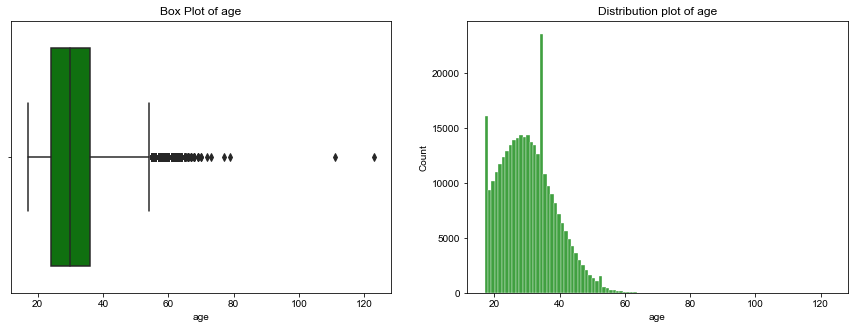

In [13]:
plotchart(df.age)

In [14]:
#Outlier detection:
out1, ind1 = findoutliers(df.age)
print(out1.shape)#217
#Even though "age" contains several outliers, the distribution is acceptable. The detected outliers are too many (if delete them, may cause information missing), we only delete the extremely value.
out2, indl2 = findoutliers2(df.age,100)
print(out2.shape)
df = df.drop(indl2,axis = 0)
df = df.reset_index(drop=True)
df.shape

(1550,)
(2,)


(316198, 6)

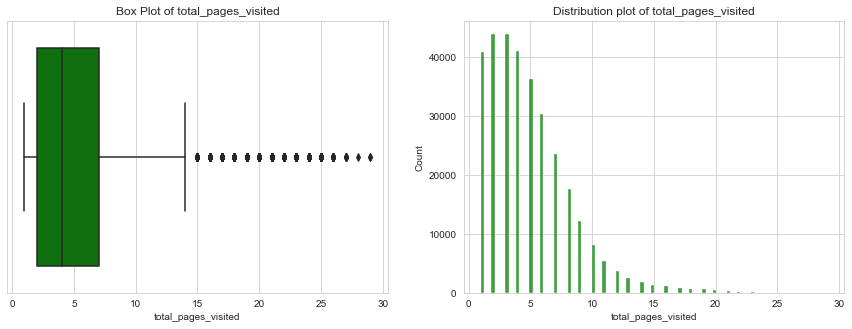

In [15]:
plotchart(df.total_pages_visited)

In [16]:
#Outlier detection:
out1, ind1 = findoutliers(df.total_pages_visited)
print(out1.shape)#217
#Even though "age" contains several outliers, the distribution is acceptable. The detected outliers are too many (if delete them, may cause information missing), we only delete the extremely value.
out2, indl2 = findoutliers2(df.total_pages_visited,25)
print(out2.shape)
df = df.drop(indl2,axis = 0)
df = df.reset_index(drop=True)
df.shape

(5662,)
(27,)


(316171, 6)

###### (b)Categorical variables

In [17]:
cat = df.select_dtypes(include = ['object'])
cat.head()

,country,source
0,UK,Ads
1,US,Seo
2,US,Seo
3,China,Seo
4,US,Seo


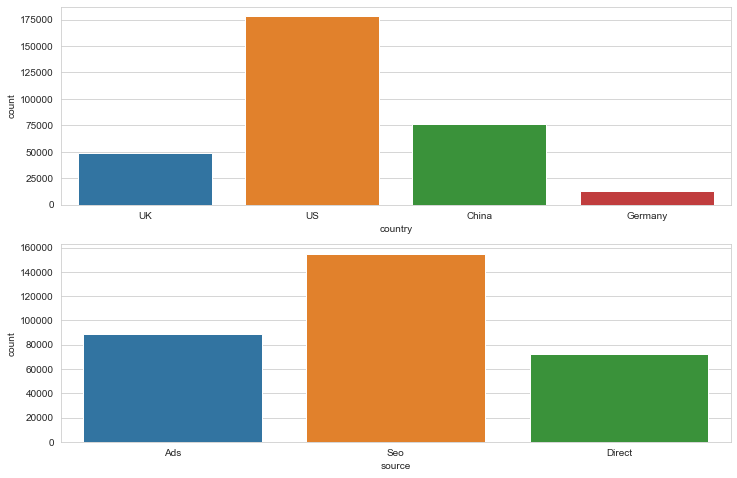

In [18]:
def plotchart2(df1):
    n=len(df1.columns)
    fig,ax = plt.subplots(n,1, figsize=(12,8))
    for i in range(n):
        plt.sca(ax[i])
        col = df1.columns[i]
        sns.countplot(x=df1[col])

plotchart2(cat)   

#### 1.5 Balance of Data Analysis

In [19]:
temp = df["converted"].value_counts()
bldf = pd.DataFrame({'labels': temp.index,
                   'values': temp.values
                  })
bldf.iplot(kind='pie',labels='labels',values='values', title='Coverted or not?')

### 2 Data Visualization/

In [20]:
df.describe(include='all')

,country,age,new_user,source,total_pages_visited,converted
count,316171,316171.000000,316171.000000,316171,316171.000000,316171.000000
unique,4,NaN,NaN,3,NaN,NaN
top,US,NaN,NaN,Seo,NaN,NaN
freq,178074,NaN,NaN,155029,NaN,NaN
mean,NaN,30.569793,0.685496,NaN,4.871067,0.032169
std,NaN,8.268964,0.464319,NaN,3.335172,0.176450
min,NaN,17.000000,0.000000,NaN,1.000000,0.000000
25%,NaN,24.000000,0.000000,NaN,2.000000,0.000000
50%,NaN,30.000000,1.000000,NaN,4.000000,0.000000
75%,NaN,36.000000,1.000000,NaN,7.000000,0.000000


In [21]:
from scipy.stats import kurtosis
from scipy.stats import skew
def datasummary(data):
    print("mean : ", np.mean(data))
    print("std  : ", np.std(data))
    print("skew : ",skew(data))
    print("kurt : ",kurtosis(data))

In [22]:
datasummary(df.total_pages_visited)

mean :  4.871066606361747
std  :  3.3351669247054945
skew :  1.4287134395480263
kurt :  3.1020967079099595


#### 2.1 The Distribution of Numerical Variables

In [23]:
data_num = df.select_dtypes(include = ['float64', 'int64'])
data_num.head()

,age,new_user,total_pages_visited,converted
0,25,1,1,0
1,23,1,5,0
2,28,1,4,0
3,39,1,5,0
4,30,1,6,0


array([[<AxesSubplot:title={'center':'age'}>,
        <AxesSubplot:title={'center':'new_user'}>],
       [<AxesSubplot:title={'center':'total_pages_visited'}>,
        <AxesSubplot:title={'center':'converted'}>]], dtype=object)

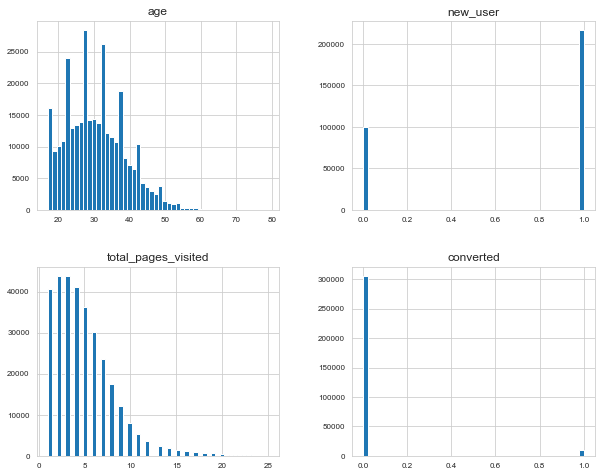

In [24]:
data_num.hist(figsize=(10, 8), bins=50, xlabelsize=8, ylabelsize=8)

#### 2.2 The Distribution of Categorical Variables

In [25]:
data_cat = df.select_dtypes(include = ['object'])
data_cat.head()

,country,source
0,UK,Ads
1,US,Seo
2,US,Seo
3,China,Seo
4,US,Seo


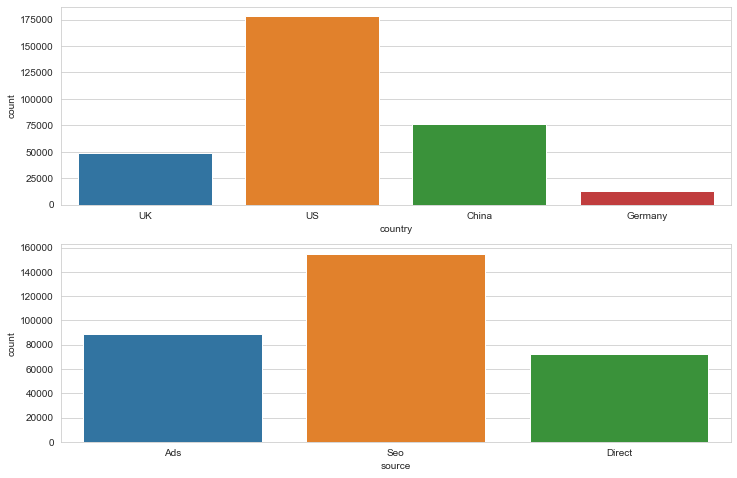

In [26]:
plotchart2(data_cat)  

### 3 Feature Correlation

<AxesSubplot:>

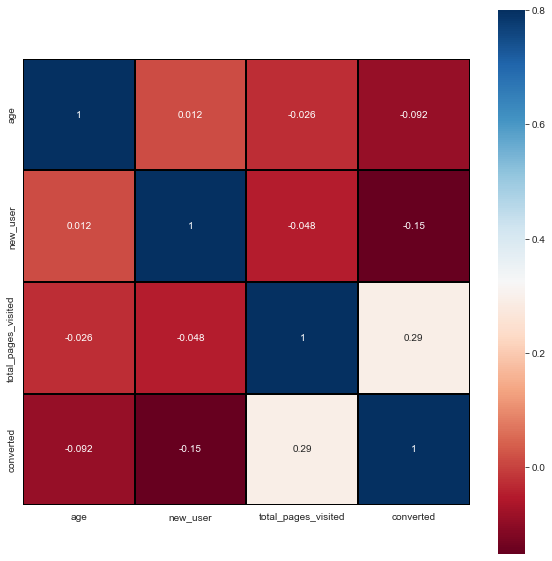

In [27]:
#Pearson’s correlation coefficient
corr = df.corr(method='spearman')
plt.figure(figsize=(10,10))
sns.heatmap(corr,vmax=0.8,linewidths=0.01,square=True,annot=True,cmap='RdBu',linecolor='black')

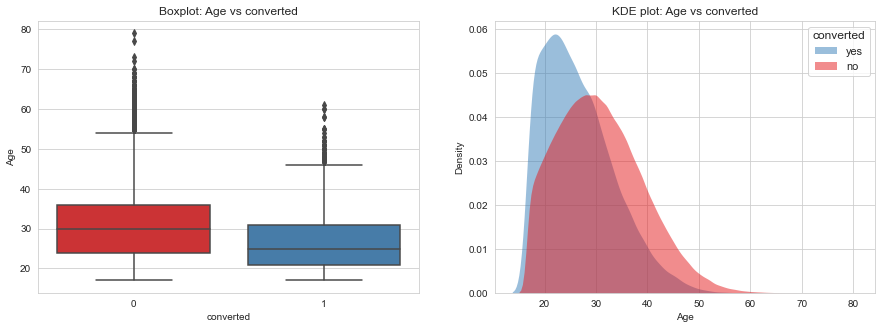

In [28]:
#1. Age vs Converted
f,ax = plt.subplots(1,2 , figsize = (15,5))
sns.set(style="whitegrid")
sns.boxplot(x="converted", y="age",  data=df, palette="Set1",ax=ax[0])
ax[0].set_title('Boxplot: Age vs converted')
ax[0].set(xlabel='converted', ylabel='Age')
sns.kdeplot(
   data=df, x="age", hue="converted",
   fill=True, common_norm=False, palette="Set1",
   alpha=.5, linewidth=0,ax=ax[1]
)
ax[1].set_title('KDE plot: Age vs converted')
ax[1].set(xlabel='Age')
ax[1].legend(title="converted",labels=['yes', 'no'])
plt.show()

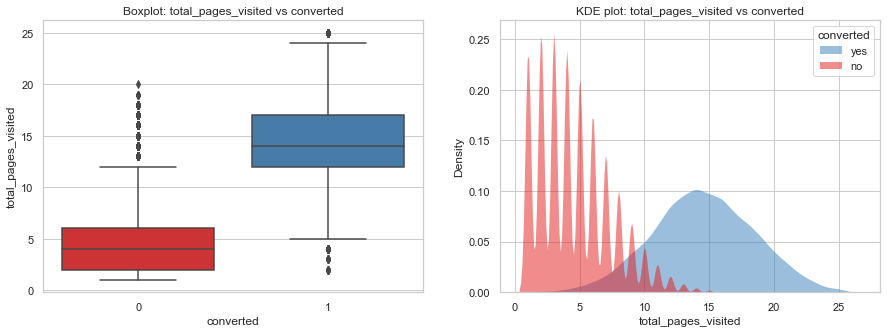

In [29]:
#1. total_pages_visited vs Converted
f,ax = plt.subplots(1,2 , figsize = (15,5))
sns.set(style="whitegrid")
sns.boxplot(x="converted", y="total_pages_visited",  data=df, palette="Set1",ax=ax[0])
ax[0].set_title('Boxplot: total_pages_visited vs converted')
ax[0].set(xlabel='converted', ylabel='total_pages_visited')
sns.kdeplot(
   data=df, x="total_pages_visited", hue="converted",
   fill=True, common_norm=False, palette="Set1",
   alpha=.5, linewidth=0,ax=ax[1]
)
ax[1].set_title('KDE plot: total_pages_visited vs converted')
ax[1].set(xlabel='total_pages_visited')
ax[1].legend(title="converted",labels=['yes', 'no'])
plt.show()

In [30]:
def CCplot(data, col, reponse):
    
    temp = data[col].value_counts()
    #print(temp.values)
    temp_y0 = []
    temp_y1 = []
    for val in temp.index:
        temp_y1.append(np.sum(data[reponse][data[col]==val] == 1))
        temp_y0.append(np.sum(data[reponse][data[col]==val] == 0))    
    trace1 = go.Bar(
        x = temp.index,
        y = (temp_y1 / temp.sum()) * 100,
        name='yes'
    )
    trace2 = go.Bar(
        x = temp.index,
        y = (temp_y0 / temp.sum()) * 100, 
        name='no'
    )

    trdf = [trace1, trace2]
    layout = go.Layout(
        title = "Bar chart: {} vs Converted".format(col),
        #barmode='stack',
        width = 800,
        xaxis=dict(
            title=col,
            tickfont=dict(
                size=14,
                color='rgb(107, 107, 107)'
            )
        ),
        yaxis=dict(
            title='Count in %',
            titlefont=dict(
                size=16,
                color='rgb(107, 107, 107)'
            ),
            tickfont=dict(
                size=14,
                color='rgb(107, 107, 107)'
            )
    )
    )

    fig = go.Figure(data=trdf, layout=layout)
    iplot(fig)

In [31]:
CCplot(df, 'source', 'converted')

In [32]:
CCplot(df, 'country', 'converted')

In [33]:
df.isnull().sum()

country                0
age                    0
new_user               0
source                 0
total_pages_visited    0
converted              0
dtype: int64

### Data Proprecessing

In [34]:
X = df.drop('converted', axis=1)
y = df['converted']

In [35]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train,  y_test = train_test_split(X, y, test_size=0.3, random_state=101)

In [36]:
print(X_train.shape)
print(X_test.shape)

(221319, 5)
(94852, 5)


In [37]:
# Feature Scaling for Numerical Data
def feature_scaling(data):
    scaler = MinMaxScaler()
    scaler.fit(data)
    data_normal = scaler.transform(data)
    data_normal = pd.DataFrame(data_normal,columns=data.columns)
    return data_normal

# One-Hot-Encoding for Categorical Data
def OneHotEncoding(d):
    col_name = d.columns
    for i in range(d.shape[1]):
        dummy = pd.get_dummies(d[col_name[i]], prefix=col_name[i])
        d = pd.concat([d, dummy], axis=1)
        d = d.drop(col_name[i], axis=1)
    return d

In [38]:
# Data transformation on Train_X and Test_X
def DataTransformation(data):
    num = data.select_dtypes(include = ['float64','int64'])
    cat = data.select_dtypes(include = ['object'])
    num_new = feature_scaling(num)
    cat_new = OneHotEncoding(cat)
    newdata = pd.concat([num_new.reset_index(drop=True), cat_new.reset_index(drop=True)], axis=1)
    return newdata

In [39]:
Train_X_trans = DataTransformation(X_train)
Test_X_trans = DataTransformation(X_test)
print(Train_X_trans.shape)
print(Test_X_trans.shape)

(221319, 10)
(94852, 10)


In [40]:
Test_X_trans.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 94852 entries, 0 to 94851
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   age                  94852 non-null  float64
 1   new_user             94852 non-null  float64
 2   total_pages_visited  94852 non-null  float64
 3   country_China        94852 non-null  uint8  
 4   country_Germany      94852 non-null  uint8  
 5   country_UK           94852 non-null  uint8  
 6   country_US           94852 non-null  uint8  
 7   source_Ads           94852 non-null  uint8  
 8   source_Direct        94852 non-null  uint8  
 9   source_Seo           94852 non-null  uint8  
dtypes: float64(3), uint8(7)
memory usage: 2.8 MB


In [41]:
# Imbalanced Data Handling

counter2 = Counter(y_train)
counter2

Counter({0: 214279, 1: 7040})

In [42]:
def smote(X,y):
    smote = SMOTENC(categorical_features=list(range(3,10)),sampling_strategy='minority',random_state = 20,k_neighbors=5)
    x_sm, y_sm = smote.fit_resample(X, y)
    return x_sm, y_sm

In [43]:
# after 
Train_X_sm, Train_Y_sm = smote(Train_X_trans,y_train)
counter = Counter(Train_Y_sm)
counter

Counter({0: 214279, 1: 214279})

In [44]:
temp = Train_Y_sm.value_counts()
dfsm = pd.DataFrame({'labels': temp.index,
                   'values': temp.values
                  })
dfsm.iplot(kind='pie',labels='labels',values='values', title='converted or not?')

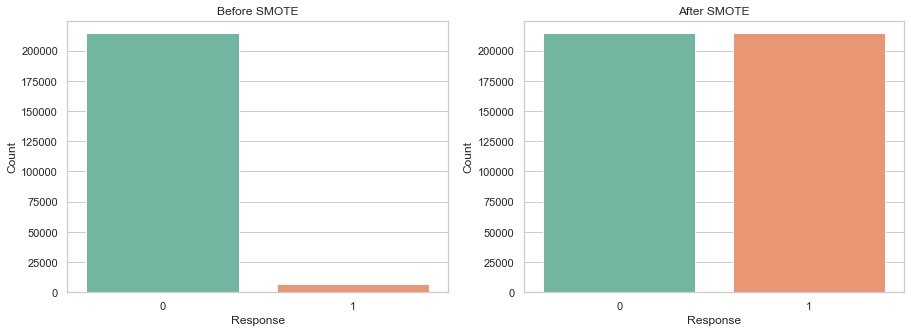

In [45]:
f,ax = plt.subplots(1,2 , figsize = (15,5))
sns.set(style="whitegrid")
sns.countplot(x=y_train, palette="Set2",ax=ax[0])
ax[0].set_title('Before SMOTE')
ax[0].set(xlabel='Response', ylabel='Count')
sns.countplot(x=Train_Y_sm, palette="Set2",ax=ax[1])
ax[1].set_title('After SMOTE')
ax[1].set(xlabel='Response', ylabel='Count')
plt.show()  

In [46]:
print(Train_X_sm.shape)
print(Train_Y_sm.shape)
print(Test_X_trans.shape)
print(y_test.shape)

(428558, 10)
(428558,)
(94852, 10)
(94852,)


### Feature Engineering

In [47]:
#before doing feature selection, you should change the following information
X = Train_X_sm
y = Train_Y_sm
num_feats = 6 #number of features to select
feature_name = X.columns.tolist()

In [48]:
# =============================================================================
# 1: Pearson Correlation
# =============================================================================
def cor_selector(X, y,num_feats):
    cor_list = []
    feature_name = X.columns.tolist()
    # calculate the correlation with y for each feature
    for i in X.columns.tolist():
        cor = np.corrcoef(X[i], y)[0, 1]
        cor_list.append(cor)
    # replace NaN with 0
    cor_list = [0 if np.isnan(i) else i for i in cor_list]
    # feature name
    cor_feature = X.iloc[:,np.argsort(np.abs(cor_list))[-num_feats:]].columns.tolist()
    # feature selection? 0 for not select, 1 for select
    cor_support = [True if i in cor_feature else False for i in feature_name]
    return cor_support, cor_feature

cor_support, cor_feature = cor_selector(X, y,num_feats)
print(str(len(cor_feature)), 'selected features')

6 selected features


In [49]:
# =============================================================================
# 2: Chi-Squared
# =============================================================================
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.preprocessing import MinMaxScaler
# X_norm = MinMaxScaler().fit_transform(X)
chi_selector = SelectKBest(chi2, k=num_feats)
chi_selector.fit(X, y)
chi_support = chi_selector.get_support()
chi_feature = X.loc[:,chi_support].columns.tolist()
print(str(len(chi_feature)), 'selected features')

6 selected features


In [50]:
# =============================================================================
# 3: Recursive Feature Elimination
# =============================================================================
rfe_selector = RFE(estimator=RandomForestClassifier(random_state=10), n_features_to_select=num_feats, step=500, verbose=5)
rfe_selector.fit(X, y)
rfe_support = rfe_selector.get_support()
rfe_feature = X.loc[:,rfe_support].columns.tolist()
print(str(len(rfe_feature)), 'selected features')

rfe_selector.n_features_
rfe_selector.support_
rfe_selector.ranking_

Fitting estimator with 10 features.
6 selected features


array([1, 1, 1, 1, 2, 1, 1, 2, 2, 2])

In [51]:
# =============================================================================
# 4: Regularization: SelectFromModel
# =============================================================================
embeded_lr_selector = SelectFromModel(LogisticRegression(penalty='l1', solver = 'saga', max_iter=1000), max_features=num_feats,threshold=-np.inf)
embeded_lr_selector.fit(X, y)

embeded_lr_support = embeded_lr_selector.get_support()
embeded_lr_feature = X.loc[:,embeded_lr_support].columns.tolist()
print(str(len(embeded_lr_feature)), 'selected features')


6 selected features


In [52]:
# =============================================================================
# 5: Tree-based: SelectFromModel
# =============================================================================
embeded_rf_selector = SelectFromModel(RandomForestClassifier(random_state=1000), max_features=num_feats,threshold=-np.inf)
embeded_rf_selector.fit(X, y)

embeded_rf_support = embeded_rf_selector.get_support()
embeded_rf_feature = X.loc[:,embeded_rf_support].columns.tolist()
print(str(len(embeded_rf_feature)), 'selected features')

6 selected features


In [53]:
# =============================================================================
# 6: Tree-based: SelectFromModel
# =============================================================================
embeded_xgb_selector = SelectFromModel(XGBClassifier(n_estimators = 100,learning_rate = 0.01, gamma=0.2, objective='binary:logistic', eval_metric='auc' ,random_state=10,use_label_encoder=False), max_features=num_feats,threshold=-np.inf)
embeded_xgb_selector.fit(X, y)

embeded_xgb_support = embeded_xgb_selector.get_support()
embeded_xgb_feature = X.loc[:,embeded_xgb_support].columns.tolist()
print(str(len(embeded_xgb_feature)), 'selected features')

6 selected features


In [54]:
# =============================================================================
# Total
# =============================================================================
# put all selection together
feature_selection_df = pd.DataFrame({'Feature':feature_name, 'Pearson':cor_support,'Chi-2':chi_support,'RFE':rfe_support, 'Regularization':embeded_lr_support,
                                    'Random Forest':embeded_rf_support, 'XGBOOST':embeded_xgb_support})

# count the selected times for each feature
feature_selection_df['Total'] = np.sum(feature_selection_df, axis=1)
# display the features in descending order
feature_selection_df = feature_selection_df.sort_values(['Total','Feature'] , ascending=False)
feature_selection_df.index = range(1, len(feature_selection_df)+1)

feature_selection_df.to_excel('feature_selection.xls', index=True)

feature_selection_df

C:\Users\yijia\anaconda3\envs\py3-TF2.0\lib\site-packages\numpy\core\fromnumeric.py:85: FutureWarning:

Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.

C:\Users\yijia\AppData\Local\Temp/ipykernel_9824/3589496566.py:14: FutureWarning:

As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.



,Feature,Pearson,Chi-2,RFE,Regularization,Random Forest,XGBOOST,Total
1,total_pages_visited,True,True,True,True,True,True,6
2,country_China,True,True,True,True,True,True,6
3,age,True,True,True,True,True,True,6
4,new_user,True,True,True,False,True,True,5
5,country_US,True,False,True,False,True,True,4
6,country_UK,True,True,True,False,True,False,4
7,source_Seo,False,False,False,True,False,True,2
8,source_Direct,False,False,False,True,False,False,1
9,source_Ads,False,False,False,True,False,False,1
10,country_Germany,False,True,False,False,False,False,1


<AxesSubplot:xlabel='Total', ylabel='Feature'>

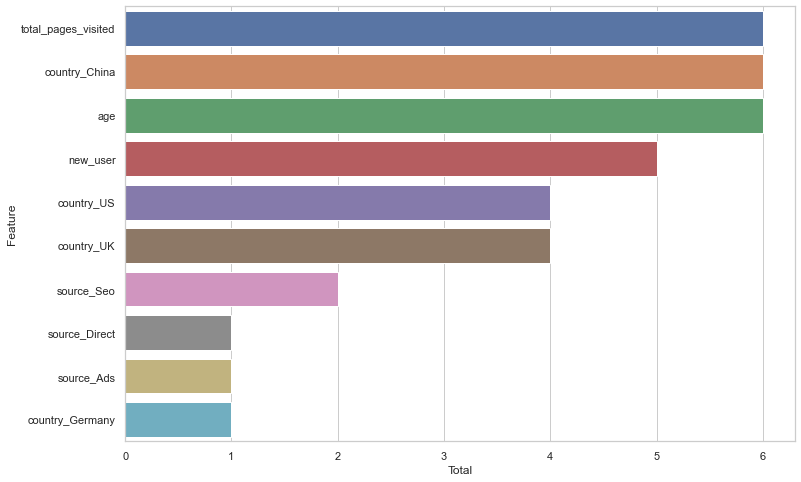

In [55]:
plt.figure(figsize=(12,8))
sns.barplot(y="Feature", x="Total", data=feature_selection_df)

In [56]:
#get score>3: set a shreshold 
selected_features = np.array(feature_selection_df['Feature'][feature_selection_df['Total']>1])
selected_features

array(['total_pages_visited', 'country_China', 'age', 'new_user',
       'country_US', 'country_UK', 'source_Seo'], dtype=object)

In [57]:
Train_XX = Train_X_sm[selected_features]
Test_XX = Test_X_trans[selected_features]

### Modeling

In [58]:
Train_YY=Train_Y_sm
Test_YY=y_test
print(Train_XX.shape)
print(Test_XX.shape)
print(Train_YY.shape)
print(Test_YY.shape)
print(Train_XX.columns)

(428558, 7)
(94852, 7)
(428558,)
(94852,)
Index(['total_pages_visited', 'country_China', 'age', 'new_user', 'country_US',
       'country_UK', 'source_Seo'],
      dtype='object')


In [59]:
#Classification: 
from sklearn.metrics import accuracy_score, f1_score, precision_recall_curve,precision_score, recall_score, roc_auc_score, roc_curve,auc,confusion_matrix,average_precision_score
def model_evaluation(name,y_test,y_pred,prediction):
    
    roc = roc_auc_score(y_test, prediction)
    auprc = average_precision_score(y_test, prediction)
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    model = pd.DataFrame([[name, acc,prec,rec, f1,roc,auprc]],columns = ['Model', 'Accuracy', 'Precision', 'Recall', 'F1 Score','AUROC','AUPRC'])
    return model

def fprtpr(y_test,prediction):
    
    fpr, tpr,_ = roc_curve(y_test, prediction)
    roc_auc = auc(fpr, tpr)
    
    return fpr, tpr, roc_auc 

def precrec(y_test,prediction):
    precision, recall, _ = precision_recall_curve(y_test,prediction)
    prc_auc = auc(recall, precision)
    return precision, recall, prc_auc

#### 3.1 Logistic Rgression

In [60]:
# build model
lrc = LogisticRegression(solver = 'saga', max_iter=1000)
lrc.fit(Train_XX, Train_YY)

LogisticRegression(max_iter=1000, solver='saga')

In [61]:
# hyperparameter tuning
param_grid_lr = {
    'solver': ['lbfgs', 'liblinear'],
    'penalty': ['none', 'l1', 'l2', 'elasticnet'],
    'C': [100, 10, 1.0, 0.1, 0.01]}


grid_search_lr = GridSearchCV(estimator = lrc, param_grid = param_grid_lr,
                               cv = 5, verbose= 5, n_jobs = -1, scoring='roc_auc')
start_time = time.time()
grid_search_lr.fit(Train_XX, Train_YY)
elapsed_time = time.time() - start_time
print("This simulation ran for",elapsed_time, "seconds, around",elapsed_time/60,"minutes.")

lr_best = grid_search_lr.best_params_
best_accuracy_lr = grid_search_lr.best_score_
print('Accuracy on Cross Validation set :',best_accuracy_lr)


Fitting 5 folds for each of 40 candidates, totalling 200 fits


C:\Users\yijia\anaconda3\envs\py3-TF2.0\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning:


100 fits failed out of a total of 200.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
25 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\yijia\anaconda3\envs\py3-TF2.0\lib\site-packages\sklearn\model_selection\_validation.py", line 681, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\yijia\anaconda3\envs\py3-TF2.0\lib\site-packages\sklearn\linear_model\_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\yijia\anaconda3\envs\py3-TF2.0\lib\site-packages\sklearn\linear_model\_logi

This simulation ran for 61.520408630371094 seconds, around 1.0253401438395182 minutes.
Accuracy on Cross Validation set : 0.9871823965880315


In [62]:
lr_best

{'C': 100, 'penalty': 'l2', 'solver': 'liblinear'}

In [63]:
#best model
start_time = time.time()
LR_model_best = LogisticRegression(**lr_best, max_iter=1000)
LR_model_best.fit(Train_XX, Train_YY)
y_pred_lr = LR_model_best.predict(Test_XX)
elapsed_time = time.time() - start_time
print("This simulation ran for",elapsed_time, "seconds, around",elapsed_time/60,"minutes.")
#model performance
prediction_lr = LR_model_best.predict_proba(Test_XX)[:, 1]
mp_lr= model_evaluation("Logistic Regression",Test_YY,y_pred_lr,prediction_lr)
    

This simulation ran for 0.8904283046722412 seconds, around 0.014840471744537353 minutes.


In [64]:
mp_lr

,Model,Accuracy,Precision,Recall,F1 Score,AUROC,AUPRC
0,Logistic Regression,0.946169,0.373316,0.929416,0.532674,0.985981,0.846752


In [65]:
import statsmodels.api as sm
logit_model=sm.Logit(Train_YY,Train_XX)
result=logit_model.fit()
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.159412
         Iterations 9
                           Results: Logit
Model:               Logit             Pseudo R-squared:  0.770      
Dependent Variable:  converted         AIC:               136648.3610
Date:                2021-12-22 23:57  BIC:               136725.1382
No. Observations:    428558            Log-Likelihood:    -68317.    
Df Model:            6                 LL-Null:           -2.9705e+05
Df Residuals:        428551            LLR p-value:       0.0000     
Converged:           1.0000            Scale:             1.0000     
No. Iterations:      9.0000                                          
---------------------------------------------------------------------
                     Coef.  Std.Err.     z     P>|z|   [0.025  0.975]
---------------------------------------------------------------------
total_pages_visited 16.5232   0.0602  274.5815 0.0000 16.4052 16.6411
country_China   

### 2 Randon Forest

In [66]:
# build model
rfc = RandomForestClassifier(random_state=12,n_jobs=-1)
rfc.fit(Train_XX, Train_YY)

RandomForestClassifier(n_jobs=-1, random_state=12)

In [67]:
# hyperparameter tuning
param_grid_rf = {
        'n_estimators':[50,100,150,200,400,600],
        'criterion':['entropy','gini'],
        'max_features':['auto', 'sqrt', 'log2'],
        'max_depth': [2,3,4,5],
        'min_samples_leaf': [2, 3, 4],
        'min_samples_split': [2,3,4]}
grid_search_rf = RandomizedSearchCV(estimator=rfc,param_distributions=param_grid_rf,n_iter =300,scoring='roc_auc',cv=5,n_jobs=-1)

start_time = time.time()
grid_search_rf = grid_search_rf.fit(Train_XX, Train_YY)
elapsed_time = time.time() - start_time
print("This simulation ran for",elapsed_time, "seconds, around",elapsed_time/60,"minutes.")

best_accuracy = grid_search_rf.best_score_
print('Accuracy on Cross Validation set :',best_accuracy)
best_parameters = grid_search_rf.best_params_

This simulation ran for 18071.790421962738 seconds, around 301.1965070327123 minutes.
Accuracy on Cross Validation set : 0.9858897034354281


In [71]:
best_parameters

{'n_estimators': 400,
 'min_samples_split': 3,
 'min_samples_leaf': 3,
 'max_features': 'auto',
 'max_depth': 5,
 'criterion': 'entropy'}

In [68]:
#best model
start_time = time.time()
RF_model_best = RandomForestClassifier(**best_parameters,random_state=22,n_jobs=-1)
RF_model_best.fit(Train_XX, Train_YY)
y_pred_rf = RF_model_best.predict(Test_XX)
elapsed_time = time.time() - start_time
print("This simulation ran for",elapsed_time, "seconds, around",elapsed_time/60,"minutes.")
#model performance
prediction_rf = RF_model_best.predict_proba(Test_XX)[:, 1]
mp_rf = model_evaluation("Random Forest",Test_YY,y_pred_rf,prediction_rf)
    

This simulation ran for 33.8085253238678 seconds, around 0.5634754220644633 minutes.


In [69]:
mp_rf

,Model,Accuracy,Precision,Recall,F1 Score,AUROC,AUPRC
0,Random Forest,0.940918,0.351114,0.931332,0.509969,0.982171,0.768898


In [72]:
from sklearn.metrics import classification_report, confusion_matrix
print(confusion_matrix(Test_YY,y_pred_rf))

[[86332  5389]
 [  215  2916]]


In [75]:
print(classification_report(Test_YY,y_pred_rf))


              precision    recall  f1-score   support

           0       1.00      0.94      0.97     91721
           1       0.35      0.93      0.51      3131

    accuracy                           0.94     94852
   macro avg       0.67      0.94      0.74     94852
weighted avg       0.98      0.94      0.95     94852



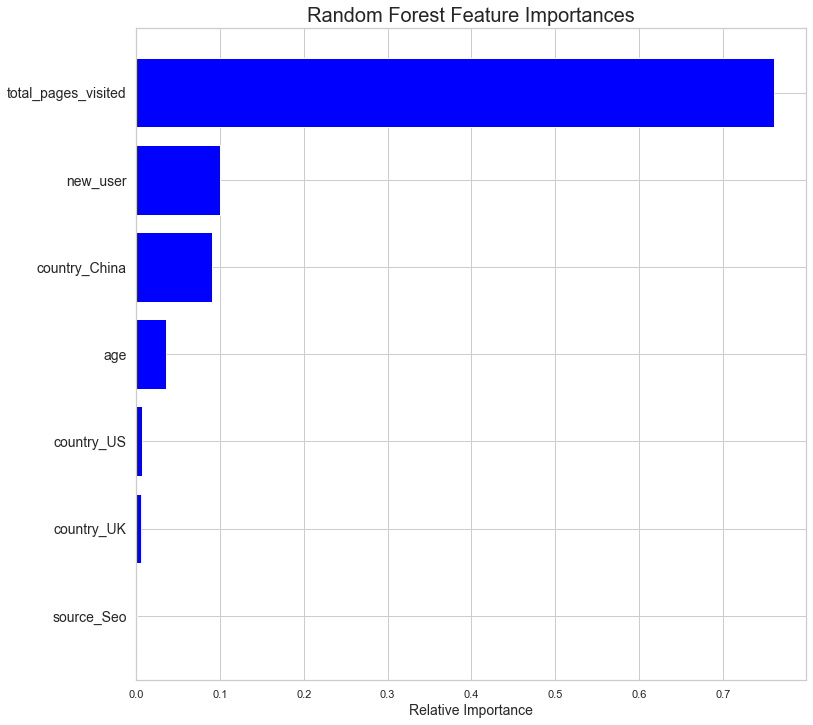

In [70]:
features = Train_XX.columns
importances = RF_model_best.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(12,12))
plt.title('Random Forest Feature Importances',fontsize=20)
plt.barh(range(len(indices)), importances[indices], color='blue', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices],fontsize=14)
plt.xlabel('Relative Importance',fontsize=14)
plt.show()